In [1]:
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
from helpers import *
from preprocessing import *
from neural_network_model import NeuralNetwork

In [2]:
x_train, x_test, y_train, train_ids, test_ids=load_csv_data("data")

## Preprocessing and Scalings

In [3]:
DATA_FOLDER = 'data/'

In [4]:
names = np.genfromtxt(DATA_FOLDER + 'x_train.csv', delimiter=",", dtype=str, max_rows=1)
names = np.delete(names, 0)
names_map = {}
for i in range(len(names)):
    names_map[names[i]] = i

In [5]:
y_train = np.where(y_train == -1, 0, y_train)
x_tr = x_train.copy()
y_tr = y_train.copy()


In [6]:
x_tr, x_val, y_tr, y_val = split_data(x_tr, y_tr, 0.8, seed=1)

In [7]:
#clean the data and return the cleaned dataset, the y values, the mean and median dictionaries to use to clean other sets (test set for example)
x_tr_clean, y_tr_clean, mean_dico, median_dico, interesting_features = clean_data(names_map, x_tr, y_tr, is_y=True, is_train_data=True)
x_val_clean, y_val_clean, _, _, _ = clean_data(names_map, x_val, y_val, is_y=True, is_train_data=False, mean_dico=mean_dico, median_dico=median_dico)

#if we don't have the y values, we use is_y=False.
x_test_clean, _, _, _, _ = clean_data(names_map, x_test, y_raw=None, is_y=False, is_train_data=False, mean_dico=mean_dico, median_dico=median_dico)

In [8]:
np.where(y_tr_clean==1)[0].shape[0]/y_tr_clean.shape[0]

0.08880491261218705

In [9]:
np.where(y_val_clean==1)[0].shape[0]/y_val_clean.shape[0]

0.08629070352141649

## Feature selection

We chose some initial features by reading the report and assessing how they seemed relevant for our predictions.

In [10]:
interesting_features_indexes=np.array([names_map[feature] for feature in interesting_features])

In [11]:
X_train=x_tr_clean[:,interesting_features_indexes].copy()
X_validation = x_val_clean[:,interesting_features_indexes].copy()
X_test=x_test_clean[:,interesting_features_indexes].copy()

### Build polynomial expansion

In [12]:
max_degree=3

# without interactions since it makes matrices too large
interactions=False

X_train_poly,features_names=build_poly_expansion_with_interaction_features(X_train,features_names=interesting_features,max_degree=max_degree,interactions=interactions)
X_val_poly,_=build_poly_expansion_with_interaction_features(X_validation,features_names=interesting_features,max_degree=max_degree,interactions=interactions)
X_test_poly,_=build_poly_expansion_with_interaction_features(X_test,features_names=interesting_features,max_degree=max_degree,interactions=interactions)

### Scale data

In [13]:
X_train_poly, train_mean_poly, train_std_poly=scale_data(X_train_poly,is_train_data=True)
X_val_poly, _, _=scale_data(X_val_poly,is_train_data=False,train_mean=train_mean_poly,train_std=train_std_poly)
X_test_poly,_,_=scale_data(X_test_poly,is_train_data=False,train_mean=train_mean_poly,train_std=train_std_poly)

### Selecting features by correlation with the outcome y

In [14]:
correlations = np.corrcoef(np.hstack([X_train_poly, y_tr_clean.reshape(-1,1)]), rowvar=False)[:, X_train_poly.shape[1]][:-1]

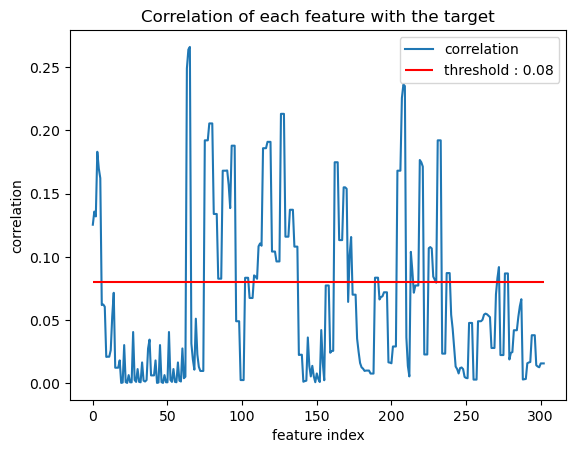

In [15]:
threshold = 0.08
plt.plot(np.abs(correlations))
plt.hlines(y=threshold, xmin=0, xmax=len(correlations) - 1, color='r')
plt.xlabel('feature index')
plt.ylabel('correlation')
plt.title('Correlation of each feature with the target')
plt.legend(['correlation', f"threshold : {threshold}"])
plt.show()

In [16]:
high_corr_indexes = np.where(correlations > threshold)[0]

In [17]:
high_corr_indexes.shape

(20,)

In [18]:
X_train_corr = X_train_poly[:, high_corr_indexes].copy()
X_val_corr = X_val_poly[:, high_corr_indexes].copy()

In [19]:
high_corr_features=list(np.array(features_names)[high_corr_indexes])
print(f"Features selected by high correlation with output (threshold)={threshold} : {len(high_corr_features)} features: \n {high_corr_features}")

Features selected by high correlation with output (threshold)=0.08 : 20 features: 
 ['POORHLTH**1', 'POORHLTH**2', 'POORHLTH**3', 'PHYSHLTH**1', 'PHYSHLTH**2', 'PHYSHLTH**3', 'GENHLTH**1', 'GENHLTH**2', 'GENHLTH**3', 'JOINPAIN**2', 'JOINPAIN**3', '_AGEG5YR**1', '_AGEG5YR**2', '_AGEG5YR**3', '_RFCHOL**1', '_RFCHOL**2', '_RFCHOL**3', 'DRNKANY5**1', 'DRNKANY5**2', 'DRNKANY5**3']


## Data augmentation

We perform data augmentation so that the model sees more positive labels. We do it by resampling positive samples. This way the model tends to predict more 1 than without and gives a better f1-score.

In [ ]:
def augment_data_with_positive_samples(X, y, ratio=0.5):
    required_ones = int(ratio * len(y))
    existing_ones_indices = np.where(y == 1)[0]
    zeros_indices = np.where(y == 0)[0]
    np.random.seed(69)
    ones_indices = np.random.choice(existing_ones_indices, required_ones - len(existing_ones_indices), replace=True)
    zeros_indices=np.random.choice(zeros_indices,len(y)-required_ones,replace=False)
    result_indices = np.concatenate([existing_ones_indices, ones_indices,zeros_indices])
    
    X_aug=X[result_indices].copy()
    y_aug=y[result_indices].copy()
    
    return X_aug, y_aug

## Ridge regression

#### With original dataset

D:\Projects\EPFL\ML-WhAI\ml-project-1-whai\implementations.py:506: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)


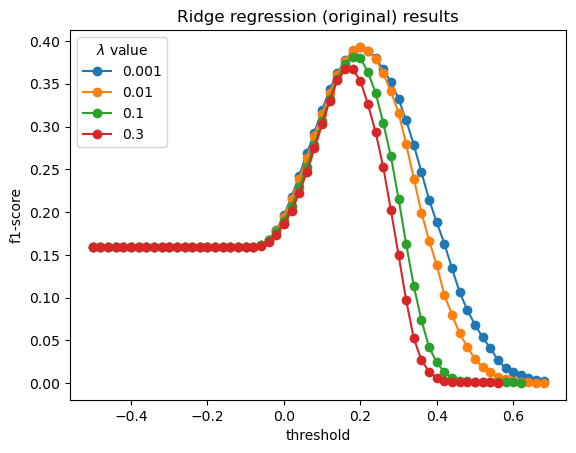

Ridge regression (original):
Best f1-score: 0.393, best lambda: 0.001, best threshold: 0.200


In [21]:
thr_l=np.arange(-0.5,0.7,0.02)
scores = []
best_score = 0
best_lambda = 0
best_threshold = 0

for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss =ridge_regression(y_tr_clean,X_train,lambda_=lambda_)
    f1_scores=[compute_scores_linear_model(X_validation,w_opt,y_val_clean,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    cur_best_score = np.nanmax(f1_scores)
    if cur_best_score > best_score:
        best_score = cur_best_score
        best_lambda = lambda_
        best_threshold = thr_l[np.nanargmax(f1_scores)]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value",loc='upper left')
plt.title("Ridge regression (original) results")
plt.show()

print(f'Ridge regression (original):\nBest f1-score: {best_score:.3f}, best lambda: {best_lambda}, best threshold: {best_threshold:.3f}')

#### With original and augmented dataset

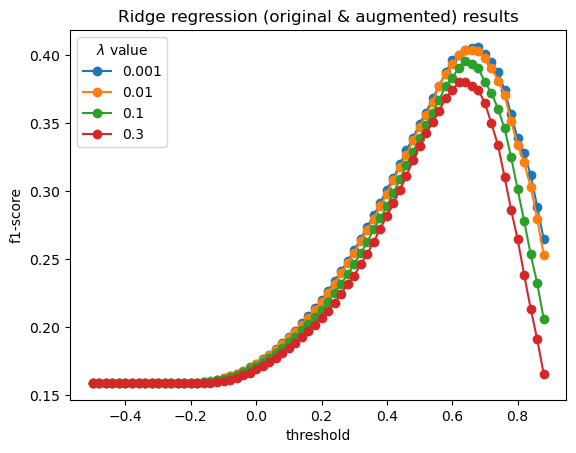

Ridge regression (original & augmented):
Best f1-score: 0.406, best lambda: 0.001, best threshold: 0.680


In [22]:
X_train_aug,y_train_clean_aug=augment_data_with_positive_samples(X_train,y_tr_clean,ratio=0.5)

thr_l=np.arange(-0.5,0.9,0.02)
best_score = 0
best_lambda = 0
best_threshold = 0

for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss =ridge_regression(y_train_clean_aug,X_train_aug,lambda_=lambda_)
    f1_scores=[compute_scores_linear_model(X_validation,w_opt,y_val_clean,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    cur_best_score = np.nanmax(f1_scores)
    if cur_best_score > best_score:
        best_score = cur_best_score
        best_lambda = lambda_
        best_threshold = thr_l[np.nanargmax(f1_scores)]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value",loc='upper left')
plt.title("Ridge regression (original & augmented) results")
plt.savefig("plots/ridge_regression_original_aug.png")
plt.show()

print(f'Ridge regression (original & augmented):\nBest f1-score: {best_score:.3f}, best lambda: {best_lambda}, best threshold: {best_threshold:.3f}')

#### With original, scaled & augmented dataset

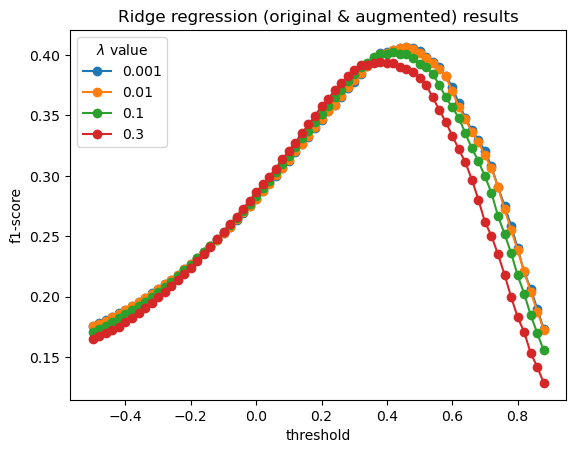

Ridge regression (original, scaled & augmented):
Best f1-score: 0.407, best lambda: 0.01, best threshold: 0.460


In [23]:
X_train_scaled, train_mean, train_std=scale_data(X_train,is_train_data=True)
X_validation_scaled, _, _=scale_data(X_validation,is_train_data=False,train_mean=train_mean,train_std=train_std)

X_train_scaled_aug,y_train_clean_aug=augment_data_with_positive_samples(X_train_scaled,y_tr_clean,ratio=0.5)

thr_l=np.arange(-0.5,0.9,0.02)
best_score = 0
best_lambda = 0
best_threshold = 0

for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss =ridge_regression(y_train_clean_aug,X_train_scaled_aug,lambda_=lambda_)
    f1_scores=[compute_scores_linear_model(X_validation_scaled,w_opt,y_val_clean,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    cur_best_score = np.nanmax(f1_scores)
    if cur_best_score > best_score:
        best_score = cur_best_score
        best_lambda = lambda_
        best_threshold = thr_l[np.nanargmax(f1_scores)]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value",loc='upper left')
plt.title("Ridge regression (original & augmented) results")
plt.show()

print(f'Ridge regression (original, scaled & augmented):\nBest f1-score: {best_score:.3f}, best lambda: {best_lambda}, best threshold: {best_threshold:.3f}')

#### With original expanded and scaled dataset

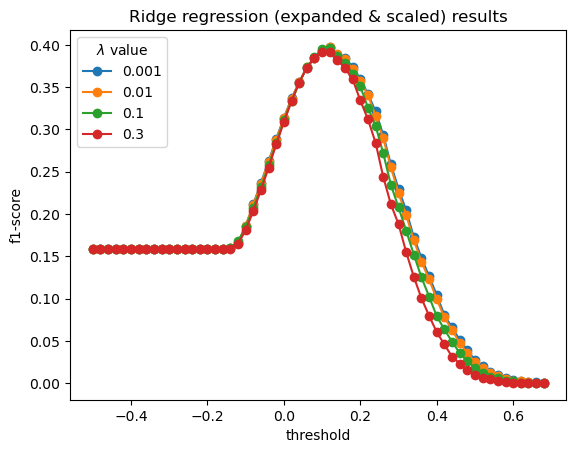

Ridge regression (expanded & scaled):
Best f1-score: 0.398, best lambda: 0.01, best threshold: 0.120


In [24]:
thr_l=np.arange(-0.5,0.7,0.02)
best_score = 0
best_lambda = 0
best_threshold = 0

for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss =ridge_regression(y_tr_clean,X_train_poly,lambda_=lambda_)
    f1_scores=[compute_scores_linear_model(X_val_poly,w_opt,y_val_clean,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    cur_best_score = np.nanmax(f1_scores)
    if cur_best_score > best_score:
        best_score = cur_best_score
        best_lambda = lambda_
        best_threshold = thr_l[np.nanargmax(f1_scores)]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value",loc='upper left')
plt.title("Ridge regression (expanded & scaled) results")
plt.show()

print(f'Ridge regression (expanded & scaled):\nBest f1-score: {best_score:.3f}, best lambda: {best_lambda}, best threshold: {best_threshold:.3f}')

#### With original expanded, scaled and augmented dataset

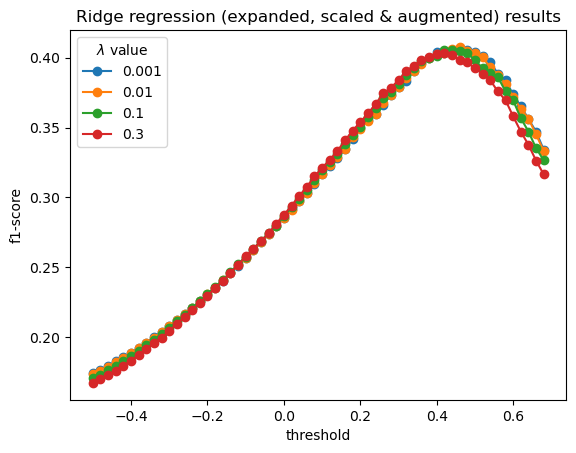

Ridge regression (expanded, scaled & augmented):
Best f1-score: 0.408, best lambda: 0.01, best threshold: 0.460


In [25]:
X_train_poly_aug,y_train_clean_aug=augment_data_with_positive_samples(X_train_poly,y_tr_clean,ratio=0.5)
best_score = 0
best_lambda = 0
best_threshold = 0

thr_l=np.arange(-0.5,0.7,0.02)
for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss =ridge_regression(y_train_clean_aug,X_train_poly_aug,lambda_=lambda_)
    f1_scores=[compute_scores_linear_model(X_val_poly,w_opt,y_val_clean,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    cur_best_score = np.nanmax(f1_scores)
    if cur_best_score > best_score:
        best_score = cur_best_score
        best_lambda = lambda_
        best_threshold = thr_l[np.nanargmax(f1_scores)]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value",loc='upper left')
plt.title("Ridge regression (expanded, scaled & augmented) results")
plt.show()

print(f'Ridge regression (expanded, scaled & augmented):\nBest f1-score: {best_score:.3f}, best lambda: {best_lambda}, best threshold: {best_threshold:.3f}')

#### With dataset of correlation selection features

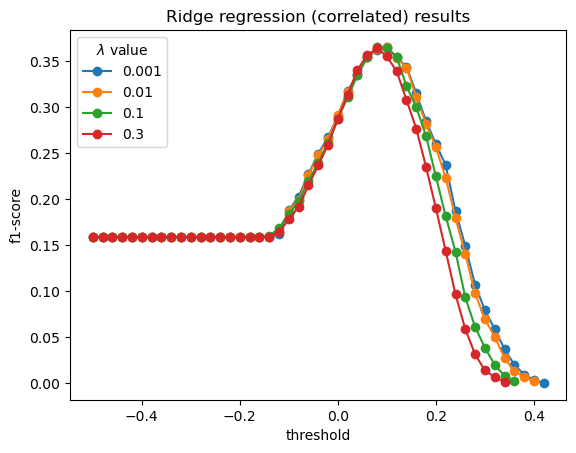

Ridge regression (correlation selection):
Best f1-score: 0.365, best lambda: 0.01, best threshold: 0.100


In [26]:
thr_l=np.arange(-0.5,0.7,0.02)
best_score = 0
best_lambda = 0
best_threshold = 0

for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss =ridge_regression(y_tr_clean,X_train_corr,lambda_=lambda_)
    f1_scores=[compute_scores_linear_model(X_val_corr,w_opt,y_val_clean,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    cur_best_score = np.nanmax(f1_scores)
    if cur_best_score > best_score:
        best_score = cur_best_score
        best_lambda = lambda_
        best_threshold = thr_l[np.nanargmax(f1_scores)]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value",loc='upper left')
plt.title("Ridge regression (correlated) results")
plt.show()

print(f'Ridge regression (correlation selection):\nBest f1-score: {best_score:.3f}, best lambda: {best_lambda}, best threshold: {best_threshold:.3f}')

#### With dataset of correlated features and augmented

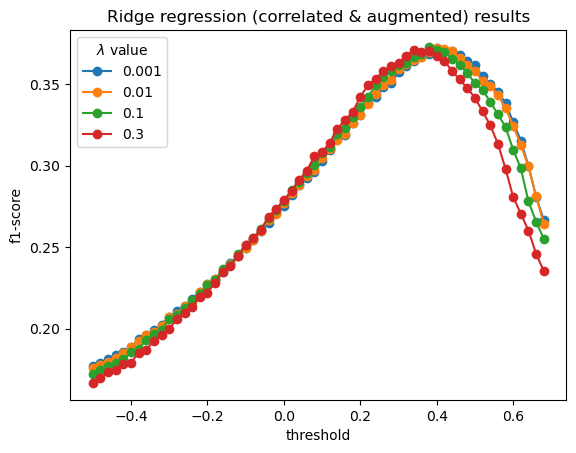

Ridge regression (correlation selection & augmented):
Best f1-score: 0.373, best lambda: 0.1, best threshold: 0.380


In [27]:
X_train_corr_aug,y_train_clean_aug=augment_data_with_positive_samples(X_train_corr,y_tr_clean,ratio=0.5)
best_score = 0
best_lambda = 0
best_threshold = 0

thr_l=np.arange(-0.5,0.7,0.02)
for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss =ridge_regression(y_train_clean_aug,X_train_corr_aug,lambda_=lambda_)
    f1_scores=[compute_scores_linear_model(X_val_corr,w_opt,y_val_clean,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    cur_best_score = np.nanmax(f1_scores)
    if cur_best_score > best_score:
        best_score = cur_best_score
        best_lambda = lambda_
        best_threshold = thr_l[np.nanargmax(f1_scores)]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value",loc='upper left')
plt.title("Ridge regression (correlated & augmented) results")
plt.show()

print(f'Ridge regression (correlation selection & augmented):\nBest f1-score: {best_score:.3f}, best lambda: {best_lambda}, best threshold: {best_threshold:.3f}')

## Logistic regression

#### With original expanded, scaled and augmented dataset

This can take several minutes

In [29]:
run_log = False

In [30]:
if run_log:
    X_train_aug,y_train_clean_aug=augment_data_with_positive_samples(X_train_poly,y_tr_clean,ratio=0.5)
    w_opt, loss = logistic_regression(y_train_clean_aug,X_train_aug,initial_w=np.zeros(X_train_aug.shape[1]),max_iters=10,gamma=0.01)
    
    best_score = 0
    best_threshold = 0
    best_gamma = 0
    
    thr_l=np.arange(0.2,1,0.02)
    for gamma in [0.001,0.01,0.1,0.3,0.5,0.7]:
        w_opt, loss = logistic_regression(y_train_clean_aug,X_train_aug,initial_w=np.zeros(X_train_aug.shape[1]),max_iters=40,gamma=gamma)
        f1_scores=[compute_scores_logistic_regression(X_val_poly,w_opt,y_val_clean,threshold=t)[2] for t in thr_l]
        cur_best_score = np.nanmax(f1_scores)
        if cur_best_score > best_score:
            best_score = cur_best_score
            best_gamma = gamma
            best_threshold = thr_l[np.nanargmax(f1_scores)]
        plt.plot(thr_l,f1_scores,marker='o',label=str(gamma))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
    plt.legend(title="$\\gamma$ value", loc='upper left')
    plt.title("Log regression results (40 iterations)\nwith expanded, scaled & augmented dataset")
    
    plt.show()
    
    print(f'Log regression (expanded, scaled & augmented):\nBest f1-score: {best_score:.3f}, best gamma: {best_gamma}, best threshold: {best_threshold:.3f}')

Regularized log regression, grid search on $\lambda$ and $\gamma$:

This step is long (more than an hour) so you should not run it if you don't need to

In [31]:
compute_grid_search=False

In [32]:
if compute_grid_search:
    best_score = 0
    best_threshold = 0
    best_gamma = 0
    best_lambda_=0
    thr_l=np.arange(0.2,1,0.02)
    for lambda_ in [0.001,0.01,0.1,0.3,0.7]:
        for gamma in [0.001,0.01,0.1,0.3,0.5]:
            w_opt, loss = reg_logistic_regression(y_train_clean_aug,X_train_aug,lambda_=lambda_,initial_w=np.zeros(X_train_aug.shape[1]),max_iters=40,gamma=gamma)
            f1_scores=[compute_scores_logistic_regression(X_val_poly,w_opt,y_val_clean,threshold=t)[2] for t in thr_l]
            cur_best_score = np.nanmax(f1_scores)
            if cur_best_score > best_score:
                best_score = cur_best_score
                best_gamma = gamma
                best_lambda_=lambda_
                best_threshold = thr_l[np.nanargmax(f1_scores)]
            plt.plot(thr_l,f1_scores,marker='o',label=str(gamma)+" -"+str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
    plt.legend(title="$\\gamma - \\lambda$ value", loc='upper left')
    plt.title("Log regression results (40 iterations)\nwith initial features, scaled & augmented dataset")

    plt.show()

    print(f'Log regression (initial features, scaled & augmented dataset):\nBest f1-score: {best_score:.3f}, best lambda: {best_lambda_},best gamma: {best_gamma}, best threshold: {best_threshold:.3f}')

#### With dataset of correlated features and augmented

In [33]:
if compute_grid_search:
    X_train_corr_aug,y_train_clean_aug=augment_data_with_positive_samples(X_train_corr,y_tr_clean,ratio=0.5)
    w_opt, loss = logistic_regression(y_train_clean_aug,X_train_corr_aug,initial_w=np.zeros(X_train_corr_aug.shape[1]),max_iters=10,gamma=0.01)
    
    best_score = 0
    best_threshold = 0
    best_gamma = 0
    
    thr_l=np.arange(0.2,1,0.02)
    for gamma in [0.001,0.01,0.1,0.3,0.5,0.7]:
        w_opt, loss = logistic_regression(y_train_clean_aug,X_train_corr_aug,initial_w=np.zeros(X_train_corr_aug.shape[1]),max_iters=10,gamma=gamma)
        f1_scores=[compute_scores_logistic_regression(X_val_corr,w_opt,y_val_clean,threshold=t)[2] for t in thr_l]
        cur_best_score = np.nanmax(f1_scores)
        if cur_best_score > best_score:
            best_score = cur_best_score
            best_gamma = gamma
            best_threshold = thr_l[np.nanargmax(f1_scores)]
        plt.plot(thr_l,f1_scores,marker='o',label=str(gamma))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
    plt.legend(title="$\\gamma$ value", loc='upper left')
    plt.title("Log regression results (10 iterations)\nwith correlation selected features & augmented dataset")
    plt.show()
    
    print(f'Log regression (correlation selection & augmented):\nBest f1-score: {best_score:.3f}, best gamma: {best_gamma}, best threshold: {best_threshold:.3f}')

### Selection by ridge regression weight

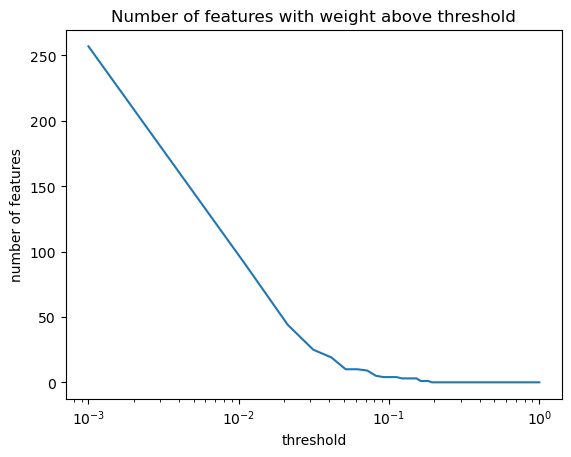

In [34]:
X_train_poly_aug,y_train_clean_aug=augment_data_with_positive_samples(X_train_poly,y_tr_clean,ratio=0.5)

w_opt_ridge,loss = ridge_regression(y_train_clean_aug,X_train_poly_aug,lambda_=0.001)
filter_ = lambda x: np.where(np.abs(w_opt_ridge) > x)[0].shape[0]
x = np.linspace(0.001, 1, 100)
plt.plot(x, np.vectorize(filter_)(x))
plt.xscale('log')
plt.xlabel('threshold')
plt.ylabel('number of features')
plt.title('Number of features with weight above threshold')
plt.show()

np.where(np.abs(w_opt_ridge) > 0.01)[0];

In [35]:
threshold = 0.03

high_weight_features=list(np.array(features_names)[np.where(np.abs(w_opt_ridge) > threshold)[0]])
print(f"Features selected by ridge regression weight (threshold)={threshold} : {len(high_weight_features)} features : \n {high_weight_features}")

Features selected by ridge regression weight (threshold)=0.03 : 25 features : 
 ['PHYSHLTH**1', 'PHYSHLTH**2', 'MENTHLTH**2', 'WEIGHT2**1', 'HEIGHT3**1', 'HEIGHT3**2', 'HEIGHT3**3', 'FRUIT1**2', 'FRUIT1**3', 'EXERHMM1**2', 'FRUTDA1_**2', 'FRUTDA1_**3', 'GENHLTH**1', 'GENHLTH**2', 'GENHLTH**3', 'CHECKUP1**1', 'CHECKUP1**2', 'DIABETE3**1', 'DIABETE3**3', '_AGEG5YR**1', '_AGEG5YR**2', '_BMI5**1', '_BMI5**2', '_PACAT1**1', '_PACAT1**3']


#### Differences between chosen features by correlation and by weight

In [36]:
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

In [37]:
print("Features chosen by correlation selection and not by ridge selection:")
diff(high_corr_features, high_weight_features)

Features chosen by correlation selection and not by ridge selection:


['POORHLTH**1',
 'POORHLTH**2',
 'POORHLTH**3',
 'PHYSHLTH**3',
 'JOINPAIN**2',
 'JOINPAIN**3',
 '_AGEG5YR**3',
 '_RFCHOL**1',
 '_RFCHOL**2',
 '_RFCHOL**3',
 'DRNKANY5**1',
 'DRNKANY5**2',
 'DRNKANY5**3']

In [38]:
print("Features chosen by ridge selection and not by correlation seleection")

diff(high_weight_features, high_corr_features)

Features chosen by ridge selection and not by correlation seleection


['MENTHLTH**2',
 'WEIGHT2**1',
 'HEIGHT3**1',
 'HEIGHT3**2',
 'HEIGHT3**3',
 'FRUIT1**2',
 'FRUIT1**3',
 'EXERHMM1**2',
 'FRUTDA1_**2',
 'FRUTDA1_**3',
 'CHECKUP1**1',
 'CHECKUP1**2',
 'DIABETE3**1',
 'DIABETE3**3',
 '_BMI5**1',
 '_BMI5**2',
 '_PACAT1**1',
 '_PACAT1**3']

#### Ridge regression with features selected by ridge regression

In [39]:
X_tr_ridge = X_train_poly[:, np.where(np.abs(w_opt_ridge) > threshold)[0]].copy()
X_val_ridge = X_val_poly[:, np.where(np.abs(w_opt_ridge) > threshold)[0]].copy()

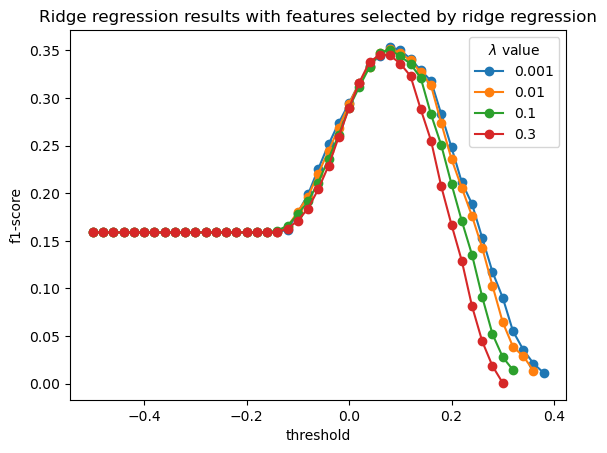

Ridge regression (features selected by ridge regression):
Best f1-score: 0.354, best lambda: 0.001, best threshold: 0.080


In [40]:
thr_l=np.arange(-0.5,0.7,0.02)
best_score = 0
best_lambda = 0
best_threshold = 0

for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss =ridge_regression(y_tr_clean,X_tr_ridge,lambda_=lambda_)
    f1_scores=[compute_scores_linear_model(X_val_ridge,w_opt,y_val_clean,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    cur_best_score = np.nanmax(f1_scores)
    if cur_best_score > best_score:
        best_score = cur_best_score
        best_lambda = lambda_
        best_threshold = thr_l[np.nanargmax(f1_scores)]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value")
plt.title("Ridge regression results with features selected by ridge regression")
plt.show()

print(f'Ridge regression (features selected by ridge regression):\nBest f1-score: {best_score:.3f}, best lambda: {best_lambda}, best threshold: {best_threshold:.3f}')

### Logistic regression with features selected by ridge regression

In [41]:
if run_log:
    best_score = 0
    best_threshold = 0
    best_gamma = 0
    
    thr_l=np.arange(0.2,1,0.02)
    for gamma in [0.001,0.01,0.1,0.3]:
        w_opt, loss = logistic_regression(y_tr_clean,X_tr_ridge,initial_w=np.zeros(X_tr_ridge.shape[1]),max_iters=40,gamma=gamma)
        f1_scores=[compute_scores_logistic_regression(X_val_ridge,w_opt,y_val_clean,threshold=t)[2] for t in thr_l]
        cur_best_score = np.nanmax(f1_scores)
        if cur_best_score > best_score:
            best_score = cur_best_score
            best_gamma = gamma
            best_threshold = thr_l[np.nanargmax(f1_scores)]
        plt.plot(thr_l,f1_scores,marker='o',label=str(gamma))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
    plt.legend(title="$\\gamma$ value")
    plt.title("Log regression results (10 iterations)")
    plt.show()
    
    print(f'Log regression (features selected by ridge regression):\nBest f1-score: {best_score:.3f}, best gamma: {best_gamma}, best threshold: {best_threshold:.3f}')

### Neural Network

the following cell takes about 15 minutes to run, it is not useful to run it !

In [42]:
run_nn=False
if run_nn:
    input_size = X_train_scaled_aug.shape[1]
    hidden_size = int(X_train_scaled_aug.shape[1]*2/3)+1
    output_size = 1
    nn_model_scaled_aug = NeuralNetwork(input_size, hidden_size, output_size)

    nn_model_scaled_aug.train(X_train_scaled_aug, y_train_clean_aug.reshape(-1,1), epochs=1500,batching=True,batch_size=32)
    print(f"training f1-score : {nn_model_scaled_aug.compute_f1_score(X_train_scaled_aug,y_train_clean_aug.reshape(-1,1))}")
    print(f"validation f1-score:{nn_model_scaled_aug.compute_f1_score(X_validation_scaled,y_val_clean.reshape(-1,1))}")


The scores we get by running the previous cell:

In [43]:
print(f"training f1-score : {0.755050088}")
print(f"validation f1-score:{0.358245468}")

training f1-score : 0.755050088
validation f1-score:0.358245468


## Submission

This is the model we chose to submit, that is ridge_regression for scaled and augmented dataset
- lambda = 0.01
- threshold = 0.460
- ratio to augment data = 0.5

In [44]:
X_train_scaled, train_mean, train_std=scale_data(X_train,is_train_data=True)
X_validation_scaled, _, _=scale_data(X_validation,is_train_data=False,train_mean=train_mean,train_std=train_std)
X_test_scaled, _, _=scale_data(X_test,is_train_data=False,train_mean=train_mean,train_std=train_std)

X_train_scaled_aug,y_train_clean_aug=augment_data_with_positive_samples(X_train_scaled,y_tr_clean,ratio=0.5)

w_opt, loss = ridge_regression(y_train_clean_aug,X_train_scaled_aug,lambda_=0.01)

res_pred = make_predictions_linear_model(X_test_scaled, w_opt, threshold=0.460)

res_pred[res_pred == 0] = -1
create_csv_submission(test_ids, res_pred, 'submission.csv')